In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#tell numpy not to parralelise so that we can do the parralelisation ourselves
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1" 
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

In [3]:
#!pip install mpire

In [4]:
import scipy
from matplotlib.colors import to_rgba
from time import time
from mpire import WorkerPool

from koala import example_graphs as eg
from koala import plotting as pl
from koala import hamiltonian as h
from koala.flux_finder import fluxes_to_labels, fluxes_from_bonds

In [5]:
e_threshold = 0.1

def gap(Js, e_threshold, e_range, lattice, coloring, ujk):
    maj_ham = h.generate_majorana_hamiltonian(lattice, coloring, ujk, Js)
    #maj_energies = np.linalg.eigvalsh(maj_ham)
    maj_energies = scipy.linalg.eigvalsh(maj_ham, subset_by_value = (-e_range,e_range))
    return np.count_nonzero(np.abs(maj_energies) < e_threshold), min(np.abs(maj_energies))


def compute_phase_diagram(sampling_points, function, extra_args, n_jobs = 6):
    print(f"Starting computation over {len(sampling_points)} points with {n_jobs} parallel procesess.")
    def computation(extra_args, Js):
        return np.array([function(J, **extra_args) for J in Js])

    t0 = time()
    with WorkerPool(n_jobs = n_jobs, shared_objects = extra_args) as pool: 
        data = pool.map(computation, sampling_points, progress_bar = True).T
        
    dt = time() - t0
    print(f'That tooks {dt:.2f} seconds or {dt/len(sampling_points)*1000*n_jobs:.0f}ms per sample point')

    return data

def plot_phase_diagram(lattice, ujk, triangulation, number_in_range, gaps, axes = None):
    if axes is None: f, axes = plt.subplots(ncols = 3, figsize = (12,4))

    ax = axes[0]
    ax.set(title = f'Lattice and Flux Sector', xticks = [], yticks = [])
    pl.plot_edges(lattice, ax = ax)

    pl.plot_plaquettes(lattice, fluxes_to_labels(fluxes_from_bonds(lattice, ujk)),
                       ax=ax,color_scheme=[to_rgba('blue',0.5), to_rgba('orange', 0.5)])

    ax = axes[1]
    ax.set(title = f'# states within {e_threshold:.2f} of 0')
    plot_triangle(ax)
    ax.triplot(triangulation, 'ko-', markersize = 1)
    ax.tricontourf(triangulation, number_in_range)

    ax = axes[2]
    ax.set(title = f'Smallest eigenvalue')
    plot_triangle(ax)
    ax.triplot(triangulation, 'ko-', markersize = 1)
    ax.tricontourf(triangulation, gaps)
    
def plot_tri(ax, data, triangulations):
    # ax.axis('off')
    ax.axes.get_yaxis().set_visible(False)
    vmin, vmax = np.min(data), np.max(data)
    
    for t in triangulations: 
        ax.triplot(t, 'k.', markersize = 1)
        ax.tricontourf(t, data, vmin = vmin, vmax = vmax, zorder = -1)
        
def plot_phase_diagram_symmetric(lattice, ujk, triangulation, number_in_range, gaps, axes = None):
    if axes is None: f, axes = plt.subplots(ncols = 3, figsize = (12,4))

    ax = axes[0]
    ax.set(title = f'Lattice and Flux Sector', xticks = [], yticks = [])
    pl.plot_edges(lattice, ax = ax)

    pl.plot_plaquettes(lattice, fluxes_to_labels(fluxes_from_bonds(lattice, ujk)),
                       ax=ax,color_scheme=[to_rgba('blue',0.5), to_rgba('orange', 0.5)])

    ax = axes[1]
    ax.set(title = f'# states within {e_threshold:.2f} of 0')
    plot_triangle(ax)
    plot_tri(ax, number_in_range, triangulation)

    ax = axes[2]
    ax.set(title = f'Smallest eigenvalue')
    plot_triangle(ax)
    plot_tri(ax, gaps, triangulation)

  0%|                                                                         | 0/15 [00:00<?, ?it/s]

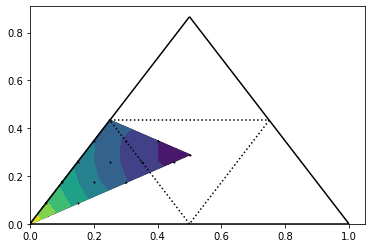

In [6]:
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import numpy as np

from matplotlib.collections import LineCollection
def plot_triangle(ax):
    points = np.array([[0,0], [np.cos(np.pi/3),np.sin(np.pi/3)], [1,0]])
    lines = [[points[i], points[(i+1)%3]] for i in range(3)]
    sub_triangle_points = [(points[i] + points[(i+1)%3])/2 for i in range(3)]
    sub_triangle_lines = [[sub_triangle_points[i], sub_triangle_points[(i+1)%3]] for i in range(3)]
    
    ax.add_collection(LineCollection(sub_triangle_lines, color = 'k', linestyle = 'dotted'))
    ax.add_collection(LineCollection(lines, color = 'k'))

def get_non_symmetric_triangular_sampling_points(samples = 10):
    # Create triangulation.
    # Start with the unit square
    Jx = np.linspace(0,0.5,samples)
    Jy = np.linspace(0,0.5,samples)
    grid_spacing = 0.5 / samples

    points = np.array([(x,y) for y in Jy for x in Jx])

    # Get rid of the uneccessary half of the square giving a right triangle
    xs,ys = points.T
    w = np.where(xs + ys <= 1)
    points = points[w]
    xs,ys = points.T
    zs = 1 - xs - ys
    triple_points = np.array([xs, ys, zs]).T
    
    # Transform the right triangle into an equilateral one for plotting
    theta = np.pi/3
    T = np.array([[1, np.cos(theta)],
                  [0, np.sin(theta)]])

    tpoints = np.einsum('ij,kj -> ki', T, points)
    triangulation = mtri.Triangulation(*tpoints.T)
    
    return triple_points, triangulation
    
def get_triangular_sampling_points(samples = 10):
    # Create triangulation.
    # Start with the unit square
    Jx = np.linspace(0,0.5,samples)
    Jy = np.linspace(0,0.5,samples)
    grid_spacing = 1 / samples

    points = np.array([(x,y) for y in Jy for x in Jx])

    xs,ys = points.T
    zs = 1 - xs - ys
    
    shape = (zs - ys >= -grid_spacing/2) & (ys - xs >= -grid_spacing/2)
    points = points[shape]
    points = np.concatenate([points, [[1/3,1/3],]]) #add the center point because it sometimes gets cut off
    
    xs,ys = points.T
    zs = 1 - xs - ys
    triple_points = np.array([xs, ys, zs]).T
    
    
    def rotation(t): return np.array([[np.cos(t), -np.sin(t)],[np.sin(t), np.cos(t)]])
    reflection = np.array([[0, 1],[1, 0]])
    centerp =  np.array([0.5,np.tan(np.pi/6)/2])
    skew = np.array([[1, np.cos(np.pi/3)],
                          [0, np.sin(np.pi/3)]])
    
    triangulations = []
    for reflect in [False,True]:
        for i in range(3):
            #reflect in the diagonal 
            lpoints = points[:, ::-1].copy() if reflect else points.copy()
            
            # Transform the right triangle into an equilateral one for plotting
            lpoints = np.einsum('ij,kj -> ki', skew, lpoints)
            
            # Rotate about the center point
            lpoints -= centerp
            t = -2*np.pi/3 * i
            lpoints = np.einsum('ij,kj -> ki', rotation(t), lpoints)
            lpoints += centerp
            
            #save this triangulation
            triangulations.append(mtri.Triangulation(*lpoints.T))
    
    return triple_points, triangulations

def plot_tri(ax, data, triangulations):
    vmin, vmax = np.min(data), np.max(data)
    
    for t in triangulations: 
        ax.tricontourf(t, data, vmin = vmin, vmax = vmax)
        # ax.triplot(t, 'ko-', markersize = 1)

def fake_data(points): return np.linalg.norm(points, axis = -1)



#generate a triangulation of the space with a certain grid spacing
sampling_points, triangulations = get_triangular_sampling_points(samples = 6)

#make a lattice and pack computations that don't depend on Jxyz into shared_objects
lattice, coloring = eg.generate_honeycomb(30, True)
ujk = np.ones(lattice.n_edges)
shared_objects = dict(lattice = lattice, coloring = coloring, ujk = ujk)

#make some fake data
def f(shared_objects, Js):
    Js = Js.squeeze()
    return fake_data(Js)

#calculate the function in parralel 
from mpire import WorkerPool
with WorkerPool(n_jobs=10, shared_objects = shared_objects) as pool: 
    gaps = pool.map(f, sampling_points, progress_bar = True)


f, ax = plt.subplots()
plot_triangle(ax)
ax.triplot(triangulations[0], 'ko-', markersize = 1)
ax.tricontourf(triangulations[0], gaps)

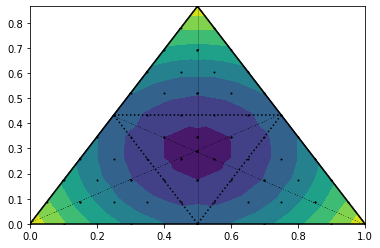

In [7]:
#do the whole diagram by repeating this slice
f, ax = plt.subplots()
plot_triangle(ax)
for tri in triangulations:
    ax.triplot(tri, 'ko-', markersize = 1)
    ax.tricontourf(tri, gaps)

# In the case where Jx Jy Jz are not interchangeable
## Plot the whole phase diagram

Starting computation over 400 points with 10 parallel procesess.


  0%|                                                                         | 0/40 [00:00<?, ?it/s]

That tooks 0.95 seconds or 24ms per sample point


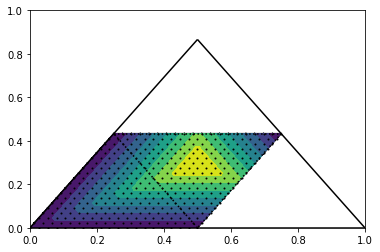

In [11]:
sampling_points, triangulation = get_non_symmetric_triangular_sampling_points(samples = 20)

def fake_data(J): return np.linalg.norm(J), min(J)

extra_args = dict()
number_in_range, gaps = compute_phase_diagram(sampling_points, fake_data, extra_args, n_jobs = 10)

f, ax = plt.subplots(ncols = 1)
ax.triplot(triangulation, 'ko-', markersize = 1)
ax.tricontourf(triangulation, gaps)
ax.set(ylim = (0,1), xlim = (0,1))
plot_triangle(ax)

Starting computation over 141 points with 10 parallel procesess.


  0%|                                                                         | 0/40 [00:00<?, ?it/s]

That tooks 0.86 seconds or 61ms per sample point


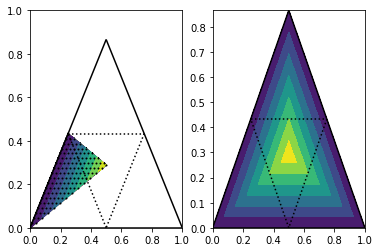

In [13]:
sampling_points, triangulations = get_triangular_sampling_points(samples = 20)
def fake_data(J): return np.linalg.norm(J), min(J)

extra_args = dict()
number_in_range, gaps = compute_phase_diagram(sampling_points, fake_data, extra_args, n_jobs = 10)

f, (ax, ax2) = plt.subplots(ncols = 2)
ax.triplot(triangulations[0], 'ko-', markersize = 1)
ax.tricontourf(triangulations[0], gaps)
ax.set(ylim = (0,1), xlim = (0,1))
plot_triangle(ax)

plot_triangle(ax2)
plot_tri(ax2, gaps, triangulations)

Starting computation over 141 points with 10 parallel procesess.


  0%|                                                                         | 0/40 [00:00<?, ?it/s]

That tooks 4.72 seconds or 335ms per sample point


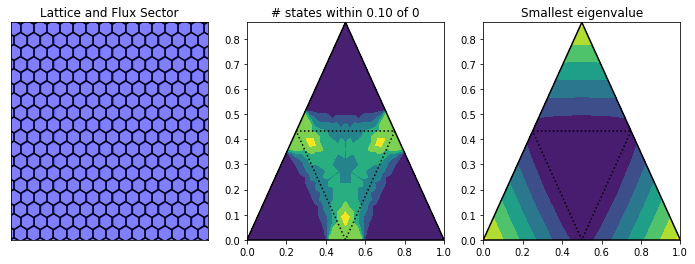

In [10]:
#if symetric just compute a slice and repeat it, otherwise do the whole thing
symmetric = True
if "results" not in globals(): results = {}

if symmetric: sampling_points, triangulation = get_triangular_sampling_points(samples = 20)
else: sampling_points, triangulation = get_non_symmetric_triangular_sampling_points(samples = 20)

lattice, coloring = eg.generate_honeycomb(15, True)
ujk = np.ones(lattice.n_edges)

extra_args = dict(lattice = lattice,
                  coloring = coloring,
                  ujk = ujk,
                  e_threshold = 0.1,
                  e_range = 0.5)

number_in_range, gaps = compute_phase_diagram(sampling_points, gap, extra_args, n_jobs = 10)

if symmetric: plot_phase_diagram_symmetric(lattice, ujk, triangulation, number_in_range, gaps)
else: plot_phase_diagram(lattice, ujk, triangulation, number_in_range, gaps)

results["Honeycomb GS"] = [lattice, ujk, triangulation, number_in_range, gaps]